KCiDMB lab5 - Transfer learning - Aleksandra Tereszkiewicz

In this notebook I created a few models to train on Pet Images dataset. To implement transfer learning I used previously trained models: VGG16 and Xception.

In [1]:
import keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/KCiDMB

Mounted at /content/drive
/content/drive/MyDrive/KCiDMB


In [3]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [4]:
def PlotAccuracyComparison(acc, val_acc, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25, 5))
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def PlotLossComparison(loss, val_loss, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25, 5))
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


##Downloading and preprocessing data

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, batch_size, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        # put the input data through the conv_base and store the outputs in features
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a for-loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels


In [6]:
# The path to store trained models
models_dir = 'models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = 'PetImages/'
original_cats = 'PetImages/cats/'
original_dogs = 'PetImages/dogs/'

# The directory where we will store our smaller dataset
base_dir = 'data2/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

train_features, train_labels = extract_features(train_dir, batch_size, 2000)
validation_features, validation_labels = extract_features(validation_dir, batch_size, 1000)
test_features, test_labels = extract_features(test_dir, batch_size, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 22ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 21ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 22ms/step


In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))
print (train_features.shape)
print (validation_features.shape)
print (test_features.shape)
flatten_layer_size = train_features.shape[1]

(2000, 8192)
(1000, 8192)
(1000, 8192)


##Dense layers

In [ ]:
import tensorflow
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model3 = models.Sequential()
model3.add(layers.Dense(256, activation='relu', input_dim=flatten_layer_size))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=tensorflow.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history3 = model3.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 7ms/step - loss: 0.7497 - acc: 0.7555 - val_loss: 0.2715 - val_acc: 0.8870
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3509 - acc: 0.8600 - val_loss: 0.2618 - val_acc: 0.8970
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2970 - acc: 0.8765 - val_loss: 0.2643 - val_acc: 0.8940
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2445 - acc: 0.9005 - val_loss: 0.3567 - val_acc: 0.8480
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2042 - acc: 0.9235 - val_loss: 0.3754 - val_acc: 0.8730
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.1907 - acc: 0.9240 - val_loss: 0.2948 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 1s 5ms/step - loss: 0.1650 - acc: 0.9315 - val_loss: 0.2743 - val_acc: 0.9050
Epoch 8/30
100/100 [==============================] - 1s 5ms/step - loss: 0.

In [ ]:
models_dir = 'C:/ml/models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

model3.save(models_dir + 'cats_and_dogs_small_3a.h5')

<Figure size 640x480 with 0 Axes>

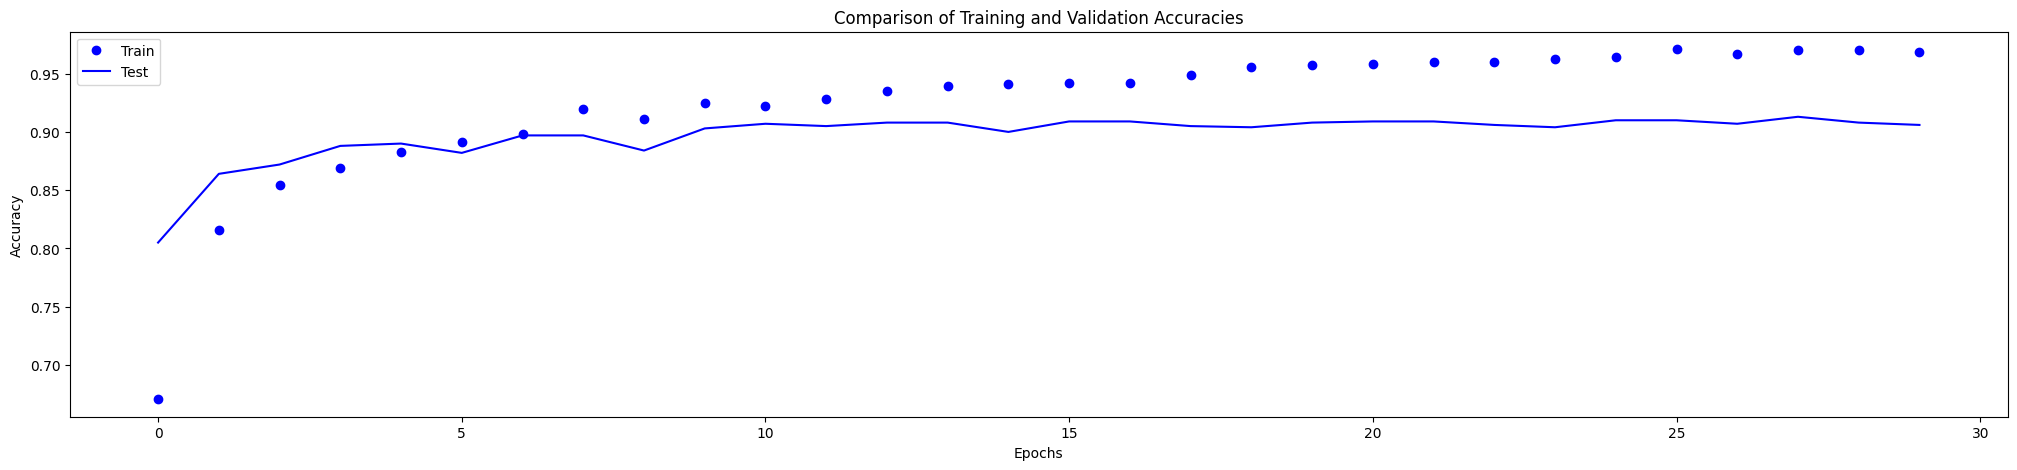

<Figure size 640x480 with 0 Axes>

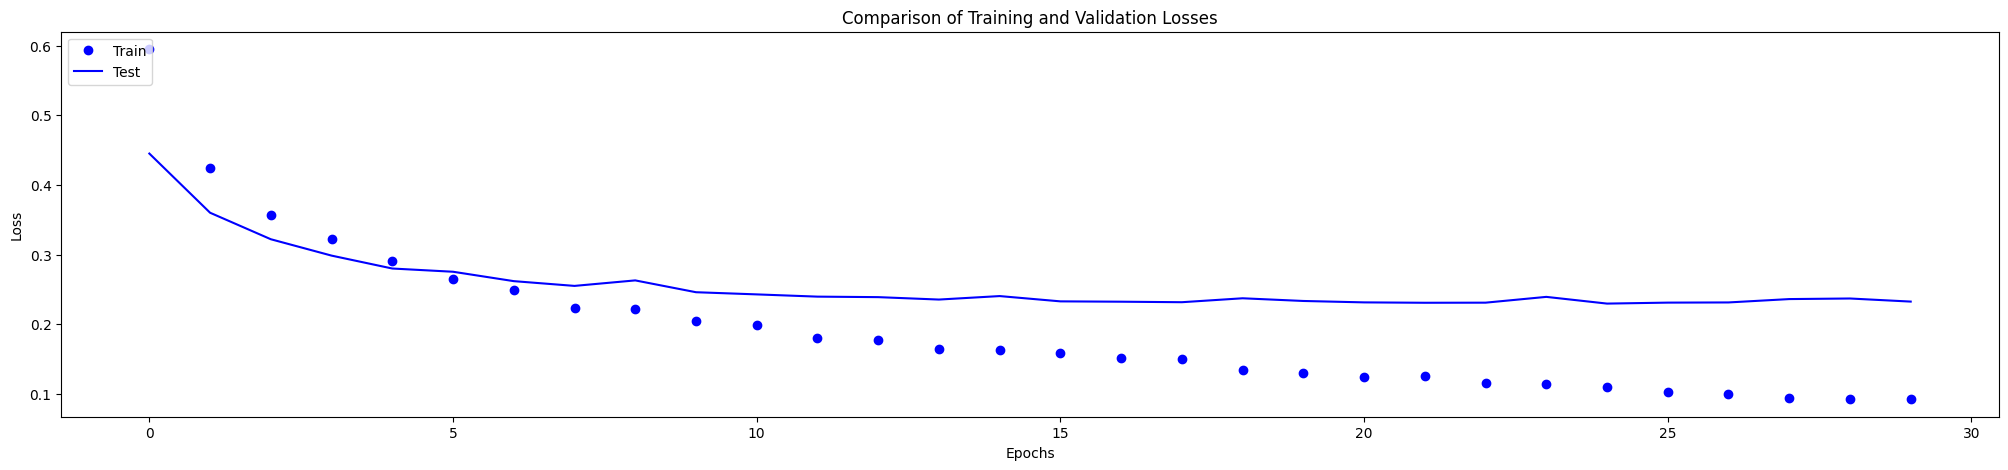

In [ ]:
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotAccuracyComparison(acc3, val_acc3, lab = 'Model 3')
PlotLossComparison(loss3, val_loss3, lab = 'Model 3')

This network doesn't train any convolutional layers and just uses the ones from VGG16 model. The accuracy is 90%.

##Unfreezing layers

In [ ]:
#here I unfroze 2 conv layers from 5th block
conv_base.trainable = True

set_trainable = True
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

len(model.trainable_weights)
model.summary()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 44s - loss: 0.6290 - acc: 0.6450 - val_

<Figure size 640x480 with 0 Axes>

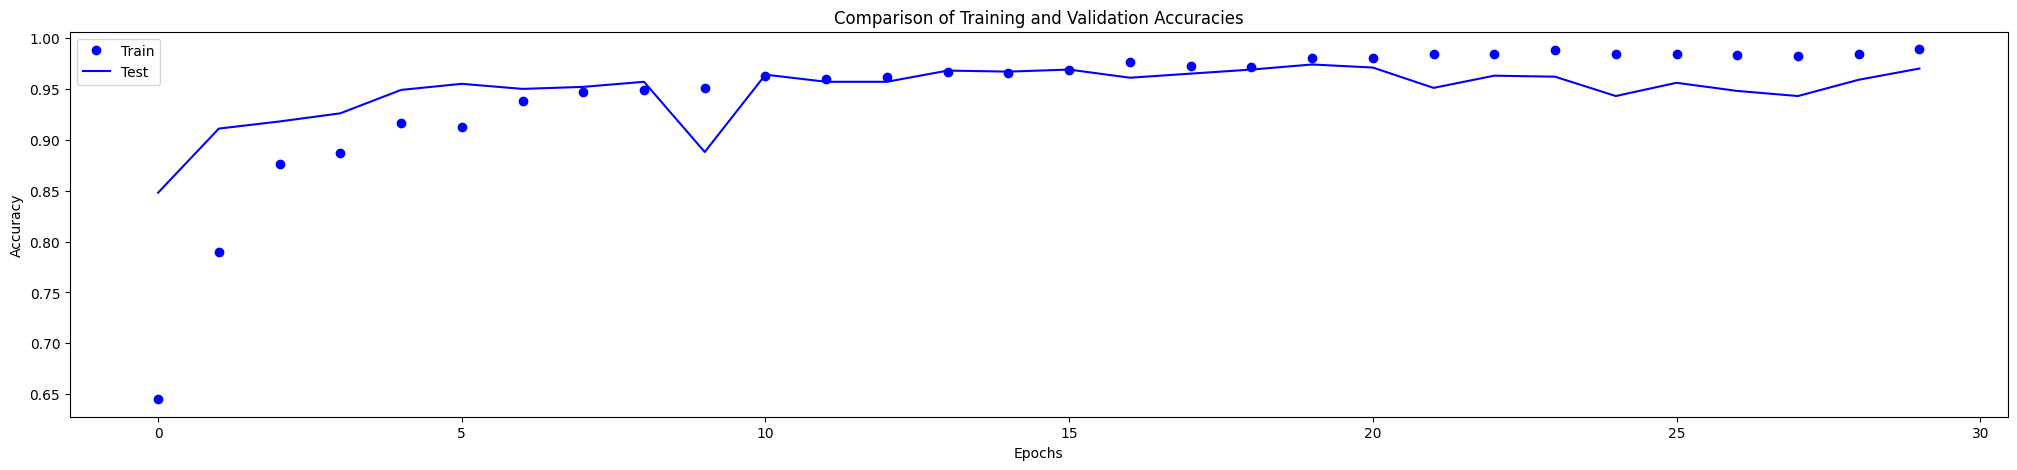

<Figure size 640x480 with 0 Axes>

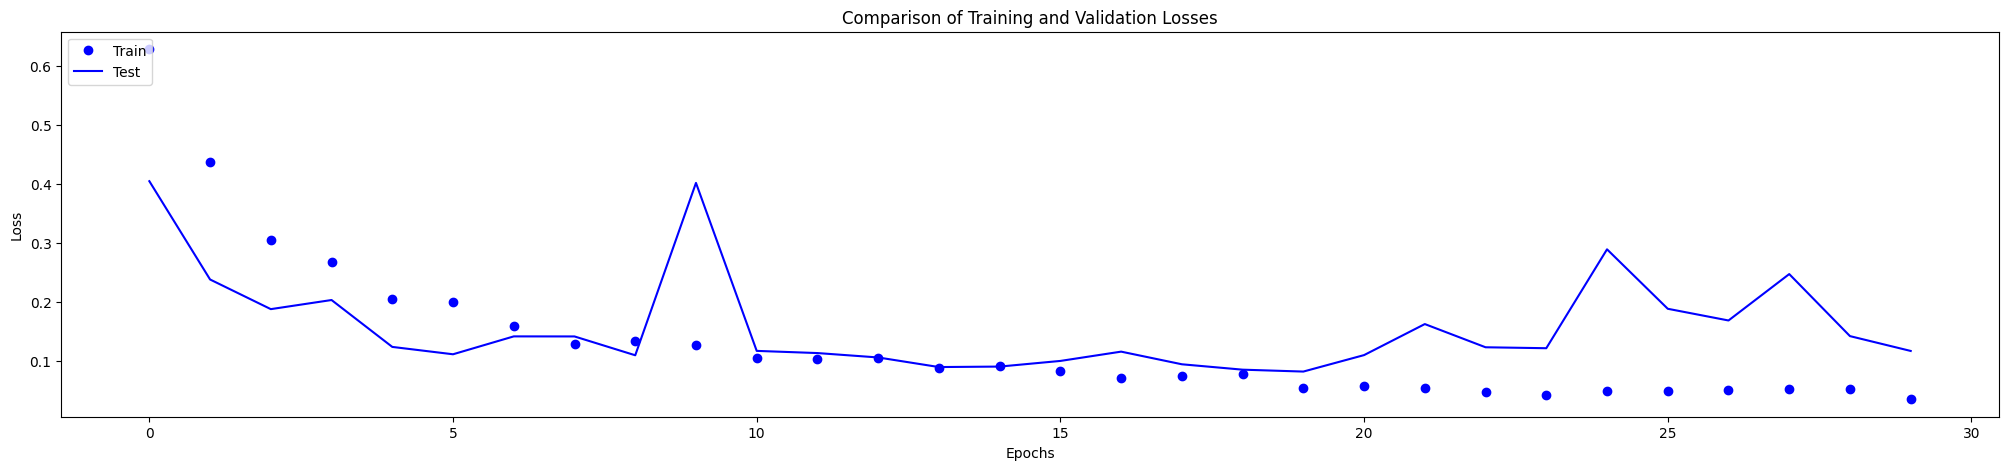

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model - unfrozen 2 conv layers from the 5th conv-block')
PlotLossComparison(loss, val_loss, lab = 'Model - unfrozen 2 conv layers from the 5th conv-block')

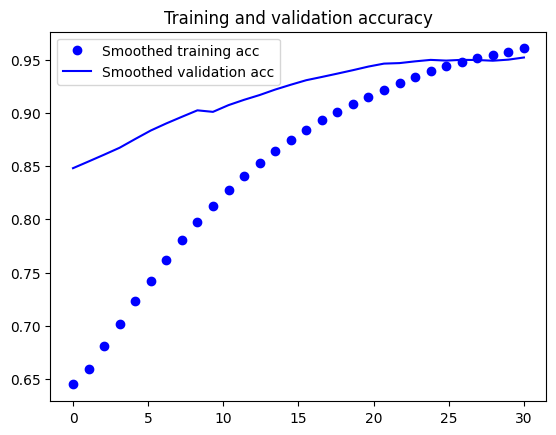

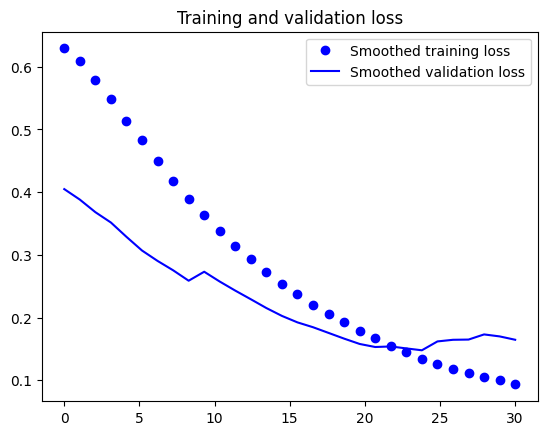

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 101ms/step - loss: 0.1125 - acc: 0.9740
test acc: 0.9739999771118164


In [ ]:
epochs = np.linspace(0, 30, 30)
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

For this model I unfroze 2 convolutional layers from block nr 5.

The accuracy is reaching 97.4% It means that I managed to set hyperparameters in a way that doesn't disturb previously trained weights.

###All layers from 5th block unfrozen

In [ ]:
set_trainable = True
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if layer.name == 'block5_conv2':
        set_trainable = True
    if layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

len(model.trainable_weights)
model.summary()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               2097408   
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 39s - loss: 0.0321 - acc: 0.9895 - val_

<Figure size 640x480 with 0 Axes>

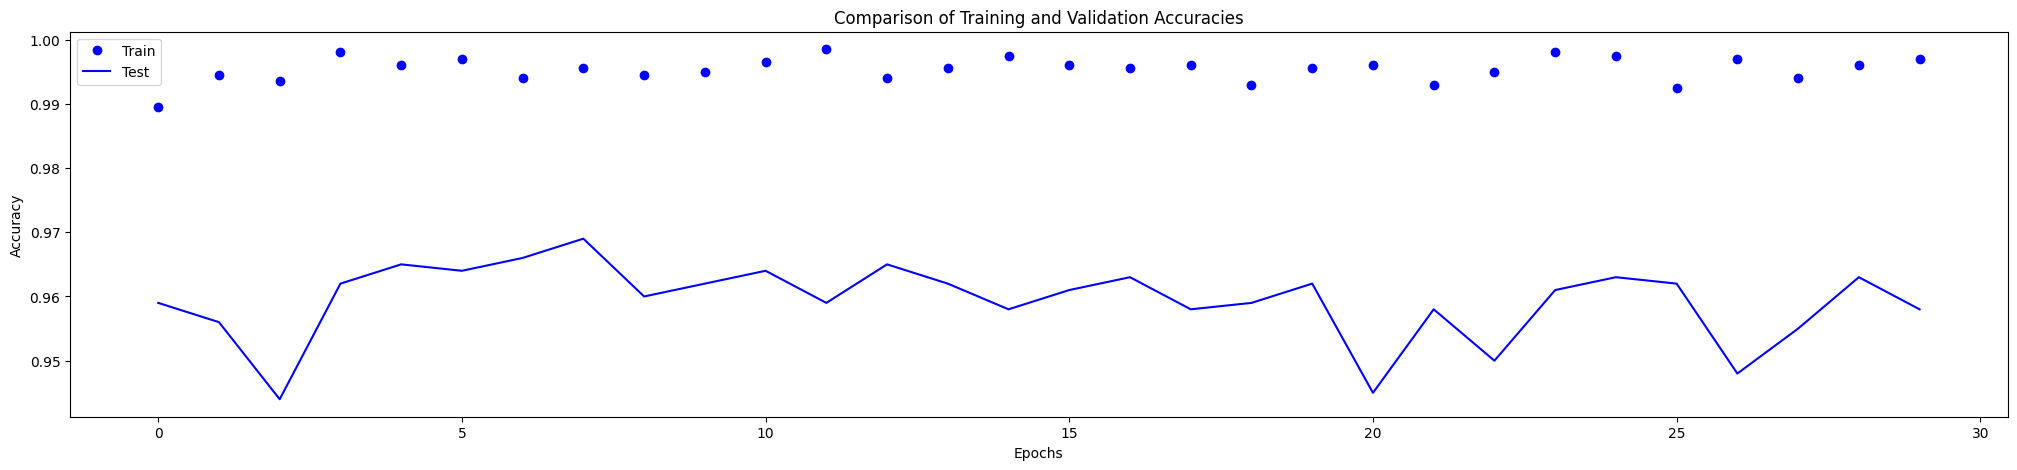

<Figure size 640x480 with 0 Axes>

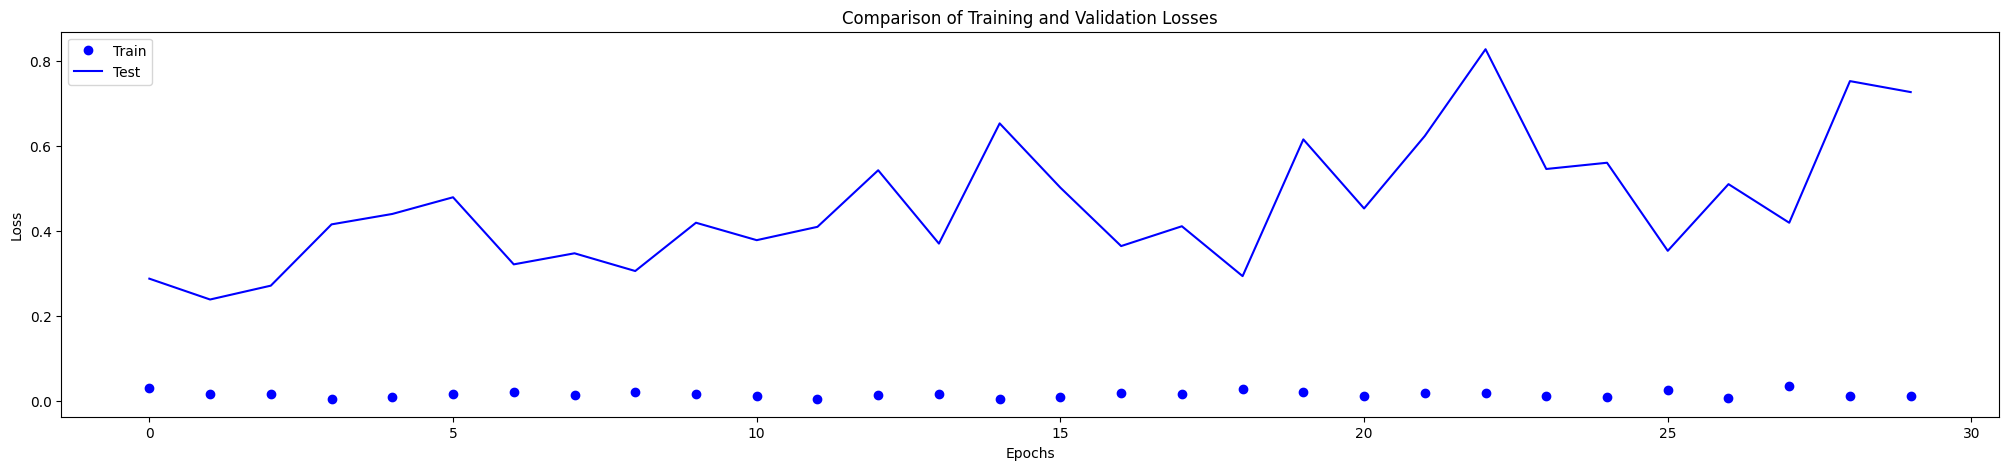

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model - unfrozen all conv layers from the 5th conv-block')
PlotLossComparison(loss, val_loss, lab = 'Model - unfrozen all conv layers from the 5th conv-block')

In [ ]:
argmax = np.argmax(val_acc)
argmin = np.argmin(val_loss)
print ('Max accuracy for this model is: ', val_acc[argmax], ', achieved in the ', argmax , 'epoch.')
print ('Min loss for this model is: ', val_loss[argmin], ', achieved in the ', argmin , 'epoch.')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Max accuracy for this model is:  0.968999981880188 , achieved in the  7 epoch.
Min loss for this model is:  0.23907490074634552 , achieved in the  1 epoch.
Found 1000 images belonging to 2 classes.
50/50 [==============================] - 7s 110ms/step - loss: 0.8199 - acc: 0.9570
test acc: 0.9570000171661377


With all convolutional layers from 5th block unfrozen, the accuracy dropped to 95.7% The reason behind this drop is too much change in original weights. To prevent this from happening, using dropout or lessening learning rate even more might be helpful.

##Fine tuning hyperparameters

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

len(model.trainable_weights)
model.summary()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

<Figure size 640x480 with 0 Axes>

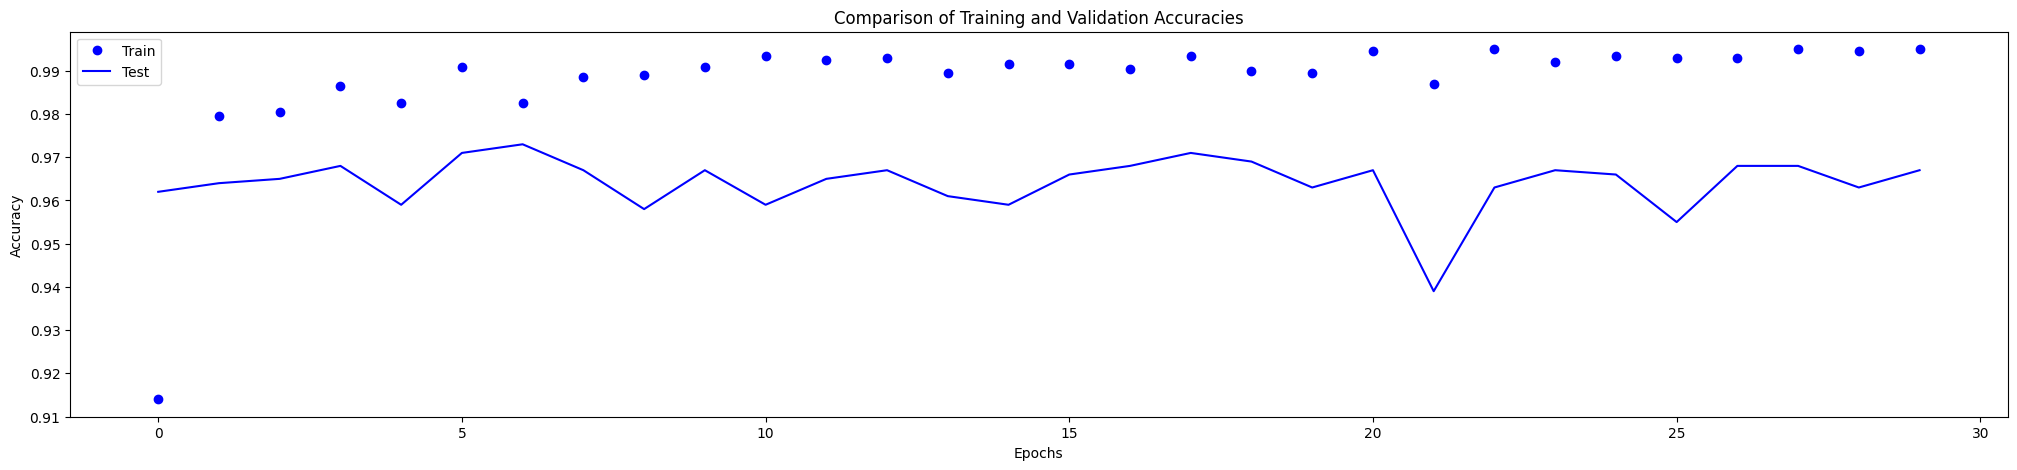

<Figure size 640x480 with 0 Axes>

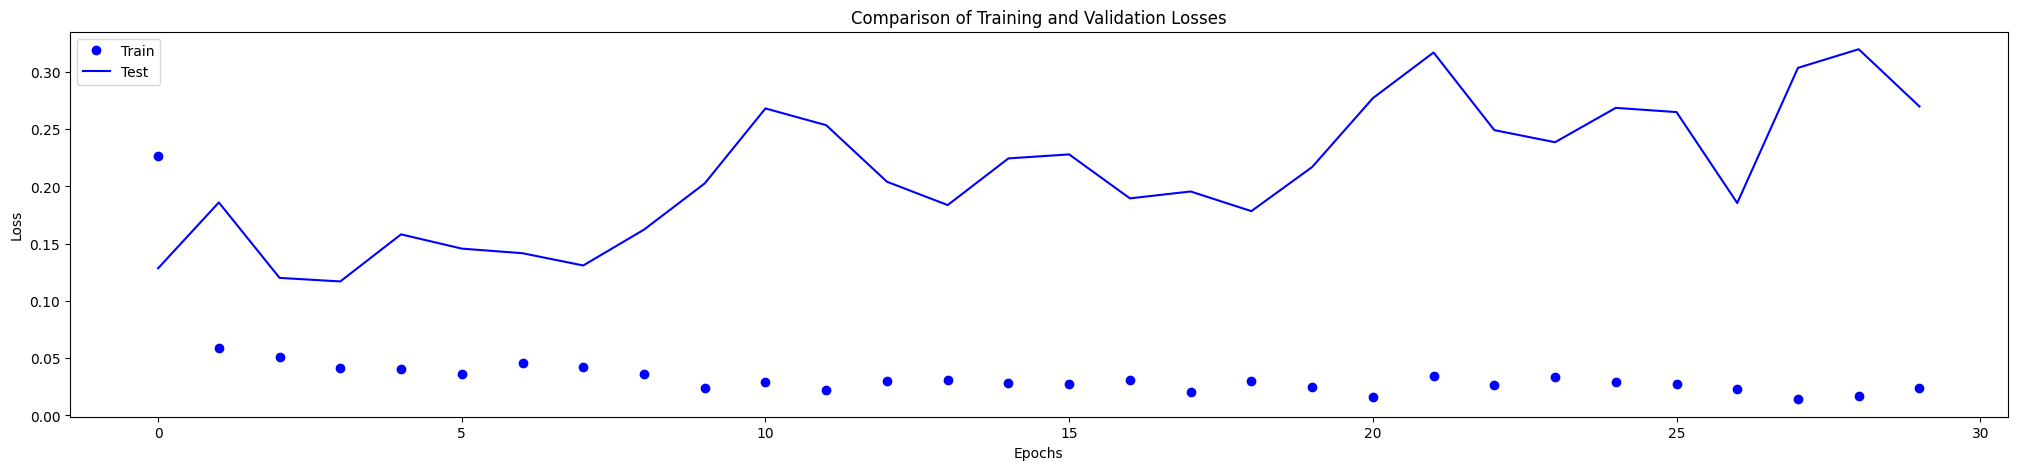

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model - fine-tuning')
PlotLossComparison(loss, val_loss, lab = 'Model - fine-tuning')

In [ ]:
argmax = np.argmax(val_acc)
argmin = np.argmin(val_loss)
print ('Max accuracy for this model is: ', val_acc[argmax], ', achieved in the ', argmax , 'epoch.')
print ('Min loss for this model is: ', val_loss[argmin], ', achieved in the ', argmin , 'epoch.')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Max accuracy for this model is:  0.9700000286102295 , achieved in the  4 epoch.
Min loss for this model is:  0.19976282119750977 , achieved in the  12 epoch.
Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 90ms/step - loss: 0.5508 - acc: 0.9610
test acc: 0.9610000252723694


In this model I added an additional dense layer with 256 filters to help classification. I also made learning rate a few times higher. It slightly helped getting accuracy to rise to 96%.

###Model 2

In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

len(model.trainable_weights)
model.summary()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 1)                

<Figure size 640x480 with 0 Axes>

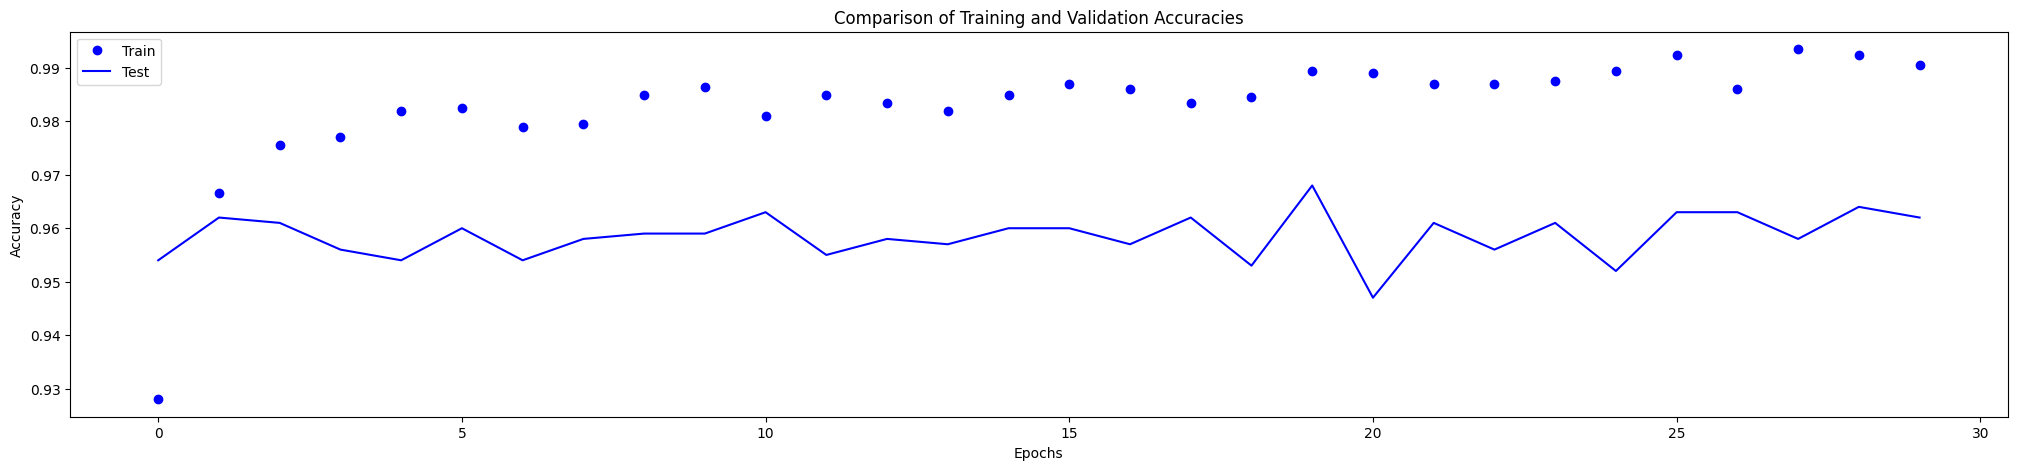

<Figure size 640x480 with 0 Axes>

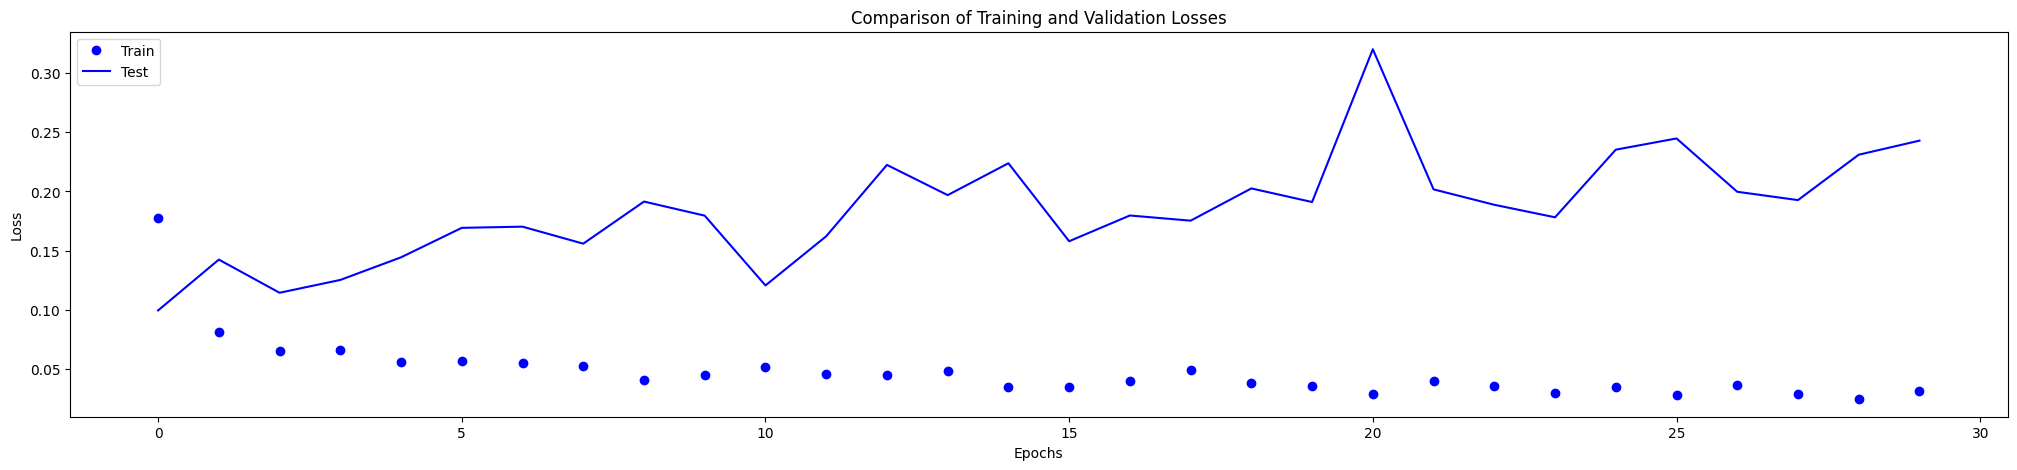

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model - fine-tuning')
PlotLossComparison(loss, val_loss, lab = 'Model - fine-tuning')

In [11]:
argmax = np.argmax(val_acc)
argmin = np.argmin(val_loss)
print ('Max accuracy for this model is: ', val_acc[argmax], ', achieved in the ', argmax , 'epoch.')
print ('Min loss for this model is: ', val_loss[argmin], ', achieved in the ', argmin , 'epoch.')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Max accuracy for this model is:  0.9679999947547913 , achieved in the  19 epoch.
Min loss for this model is:  0.09937743097543716 , achieved in the  0 epoch.
Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 97ms/step - loss: 0.3415 - acc: 0.9490
test acc: 0.9490000009536743


In this model I added additional dense layer, a dropout with value of 25% and changed learning rate back to its first value. However it didn't really help model's performance.

##Other types of convbases

In [13]:
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [15]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

len(model.trainable_weights)
model.summary()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               13107456  
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 33969193 (129.58 MB)
Trainable params: 33914665 (129.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 103s - loss: 0.4227 - acc: 0.7970

<Figure size 640x480 with 0 Axes>

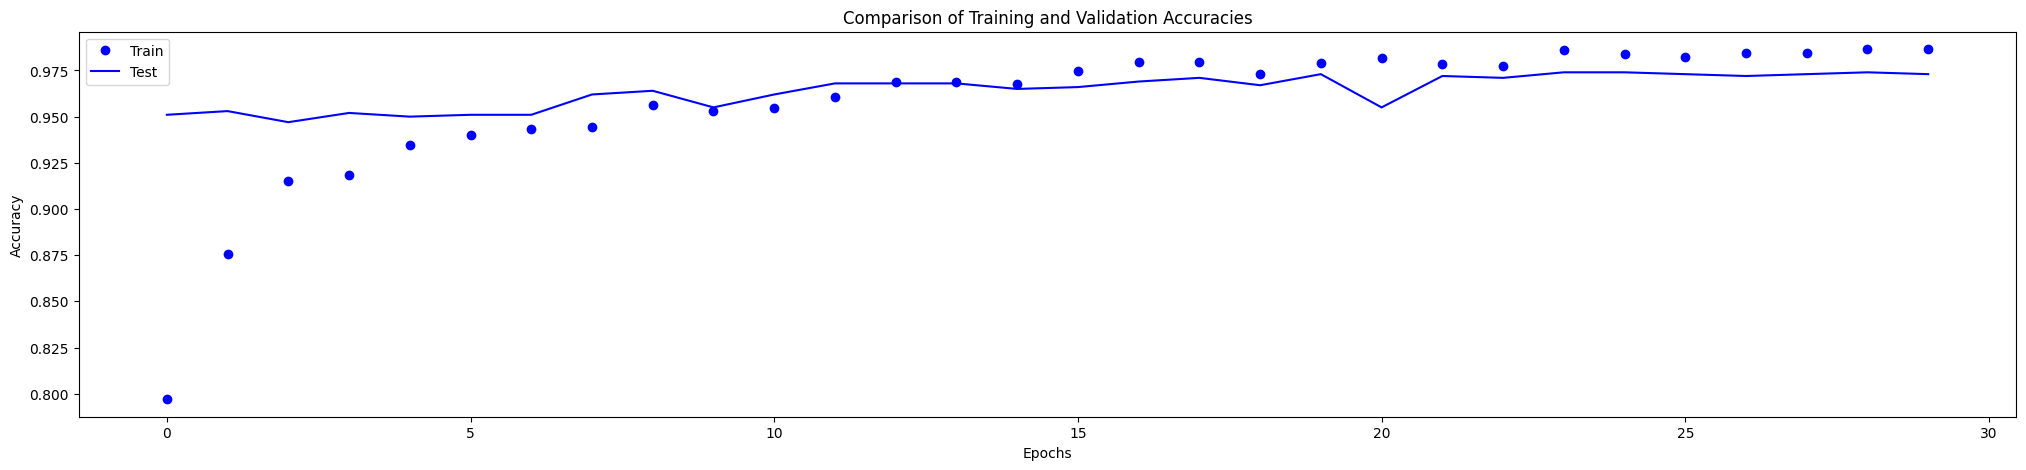

<Figure size 640x480 with 0 Axes>

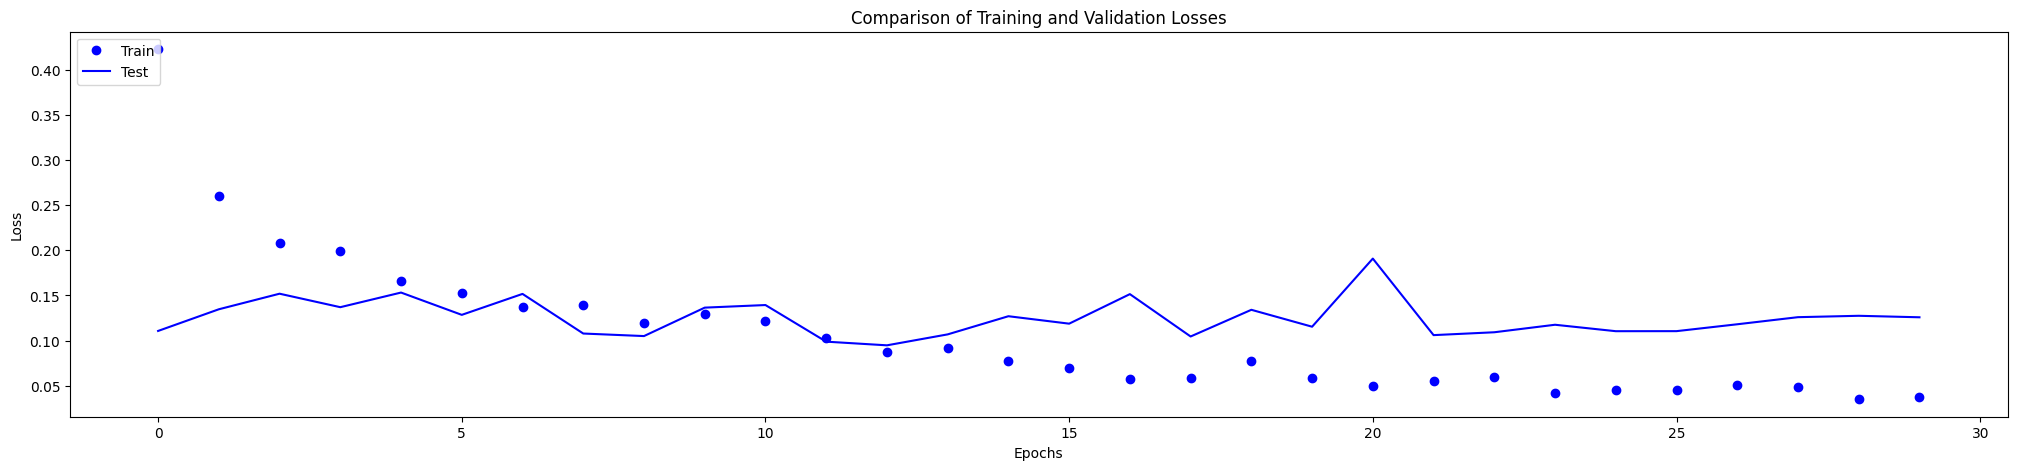

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model - 4 thousand training data')
PlotLossComparison(loss, val_loss, lab = 'Model - 4 thousand training data')

In [17]:
argmax = np.argmax(val_acc)
argmin = np.argmin(val_loss)
print ('Max accuracy for this model is: ', val_acc[argmax], ', achieved in the ', argmax , 'epoch.')
print ('Min loss for this model is: ', val_loss[argmin], ', achieved in the ', argmin , 'epoch.')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Max accuracy for this model is:  0.9739999771118164 , achieved in the  23 epoch.
Min loss for this model is:  0.09477739036083221 , achieved in the  12 epoch.
Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 100ms/step - loss: 0.1649 - acc: 0.9730
test acc: 0.9729999899864197


I chose Xception model because it has better achieved accuracy for imagenet dataset than VGG16. It is built differently because it has separable convolutions: depthwise (which produces many feature maps for each channel) and pointwise convolution (which combines previous feature maps and therefore manages to capture more complex patterns).

Separable convolutions require fewer computations compared to traditional convolutions. This is the main advantage of Xception as it allows for reduction of the number of parameters and computational complexity. This reduction in complexity can lead to faster training times, less memory usage, and better generalization.

I used the model that gave the best results with VGG16 base and received  accuracy of 97.3% which is the best for this dataset in this colab notebook.

##Summary

in this notebook I learned about transfer learning, how to obtain and work with different trained model bases, such as VGG16 and Xception, and how to get higher accuracy with trained models using fine-tuning and freezing and unfreezing layers.